In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# loading the dataset
df = pd.read_csv("/content/OnlineNewsPopularity.csv")

# looking at the first few rows just to confirm the structure
print("Preview of the dataset:")
print(df.head(), "\n")

# checking basic information about columns and data types
print("Dataset info:")
print(df.info(), "\n")

# checking missing values across all columns
print("Missing values per column:")
print(df.isnull().sum(), "\n")

# looking at basic statistics of numeric columns
print("Summary statistics:")
print(df.describe(), "\n")

Preview of the dataset:
                                                 url   timedelta  \
0  http://mashable.com/2013/01/07/amazon-instant-...       731.0   
1  http://mashable.com/2013/01/07/ap-samsung-spon...       731.0   
2  http://mashable.com/2013/01/07/apple-40-billio...       731.0   
3  http://mashable.com/2013/01/07/astronaut-notre...       731.0   
4   http://mashable.com/2013/01/07/att-u-verse-apps/       731.0   

    n_tokens_title   n_tokens_content   n_unique_tokens   n_non_stop_words  \
0             12.0              219.0          0.663594                1.0   
1              9.0              255.0          0.604743                1.0   
2              9.0              211.0          0.575130                1.0   
3              9.0              531.0          0.503788                1.0   
4             13.0             1072.0          0.415646                1.0   

    n_non_stop_unique_tokens   num_hrefs   num_self_hrefs   num_imgs  ...  \
0                   0

In [ ]:
# cleaning up the column names by stripping leading/trailing spaces
df.columns = df.columns.str.strip()
print(df.columns)

Index(['url', 'timedelta', 'n_tokens_title', 'n_tokens_content',
       'n_unique_tokens', 'n_non_stop_words', 'n_non_stop_unique_tokens',
       'num_hrefs', 'num_self_hrefs', 'num_imgs', 'num_videos',
       'average_token_length', 'num_keywords', 'data_channel_is_lifestyle',
       'data_channel_is_entertainment', 'data_channel_is_bus',
       'data_channel_is_socmed', 'data_channel_is_tech',
       'data_channel_is_world', 'kw_min_min', 'kw_max_min', 'kw_avg_min',
       'kw_min_max', 'kw_max_max', 'kw_avg_max', 'kw_min_avg', 'kw_max_avg',
       'kw_avg_avg', 'self_reference_min_shares', 'self_reference_max_shares',
       'self_reference_avg_sharess', 'weekday_is_monday', 'weekday_is_tuesday',
       'weekday_is_wednesday', 'weekday_is_thursday', 'weekday_is_friday',
       'weekday_is_saturday', 'weekday_is_sunday', 'is_weekend', 'LDA_00',
       'LDA_01', 'LDA_02', 'LDA_03', 'LDA_04', 'global_subjectivity',
       'global_sentiment_polarity', 'global_rate_positive_words',
     

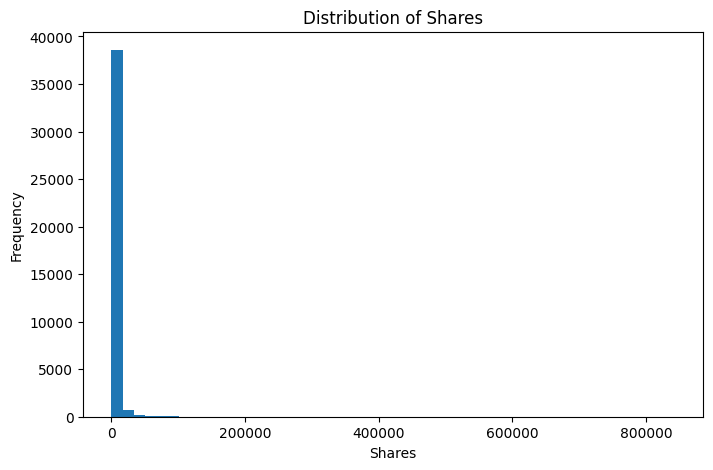

Skewness of shares: 33.96388487571415 

Top positive correlations with shares:
shares                        1.000000
kw_avg_avg                    0.110413
LDA_03                        0.083771
kw_max_avg                    0.064306
self_reference_avg_sharess    0.057789
self_reference_min_shares     0.055958
self_reference_max_shares     0.047115
num_hrefs                     0.045404
kw_avg_max                    0.044686
kw_min_avg                    0.039551
Name: shares, dtype: float64 

Top negative correlations with shares:
rate_positive_words             -0.013241
data_channel_is_tech            -0.013253
LDA_04                          -0.016622
data_channel_is_entertainment   -0.017006
min_negative_polarity           -0.019297
max_negative_polarity           -0.019300
average_token_length            -0.022007
avg_negative_polarity           -0.032029
data_channel_is_world           -0.049497
LDA_02                          -0.059163
Name: shares, dtype: float64


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# checking distribution of shares visually
plt.figure(figsize=(8,5))
plt.hist(df["shares"], bins=50)
plt.title("Distribution of Shares")
plt.xlabel("Shares")
plt.ylabel("Frequency")
plt.show()
# checking skewness value
print("Skewness of shares:", df["shares"].skew(), "\n")
# computing correlation between numeric features and shares
corr = df.corr(numeric_only=True)["shares"].sort_values(ascending=False)
print("Top positive correlations with shares:")
print(corr.head(10), "\n")
print("Top negative correlations with shares:")
print(corr.tail(10))


## Preprocessing

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif
import numpy as np
import pandas as pd

# removing the url column since it's not useful for ANN
df = df.drop(columns=["url"])

# keeping a clean copy to avoid modifying the original
data = df.copy()
# creating the binary target: 1 = popular, 0 = not popular
threshold = data["shares"].median()
data["popular"] = (data["shares"] > threshold).astype(int)
print("Class distribution (0 = not popular, 1 = popular):")
print(data["popular"].value_counts(), "\n")

# separating full features and target
X_full = data.drop(columns=["shares", "popular"])
y_full = data["popular"]

# scaling the numeric features before feature selection
scaler_full = StandardScaler()
X_scaled_full = scaler_full.fit_transform(X_full)

print("Shape before feature selection:", X_scaled_full.shape)

# applying mutual information feature selection
selector = SelectKBest(mutual_info_classif, k=25)
X_selected = selector.fit_transform(X_scaled_full, y_full)

print("Shape after feature selection:", X_selected.shape)

# getting the names of chosen features
selected_mask = selector.get_support()
selected_features = X_full.columns[selected_mask]

print("\nSelected Features:")
for col in selected_features:
    print(col)

# scaling the selected features again (clean final input)
scaler_selected = StandardScaler()
X_scaled_selected = scaler_selected.fit_transform(X_selected)

# final stratified split
X_train_sel, X_test_sel, y_train_sel, y_test_sel = train_test_split(
    X_scaled_selected,
    y_full,
    test_size=0.2,
    random_state=42,
    stratify=y_full
)

print("\nFinal training set size:", X_train_sel.shape)
print("Final test set size:", X_test_sel.shape)
print("Final feature count:", X_train_sel.shape[1])


Class distribution (0 = not popular, 1 = popular):
popular
0    20082
1    19562
Name: count, dtype: int64 

Shape before feature selection: (39644, 59)
Shape after feature selection: (39644, 25)

Selected Features:
timedelta
num_hrefs
num_imgs
data_channel_is_entertainment
data_channel_is_socmed
data_channel_is_tech
data_channel_is_world
kw_max_min
kw_avg_min
kw_min_max
kw_avg_max
kw_min_avg
kw_max_avg
kw_avg_avg
self_reference_min_shares
self_reference_max_shares
self_reference_avg_sharess
weekday_is_monday
weekday_is_saturday
is_weekend
LDA_00
LDA_01
LDA_02
LDA_03
LDA_04

Final training set size: (31715, 25)
Final test set size: (7929, 25)
Final feature count: 25


## Baseline ANN model (simple MLP)

In [5]:
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

model1 = models.Sequential()

model1.add(layers.Dense(32, activation='relu', input_shape=(X_train_sel.shape[1],)))
model1.add(layers.Dense(16, activation='relu'))
model1.add(layers.Dense(1, activation='sigmoid'))

model1.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print(model1.summary())

early1 = EarlyStopping(
    monitor='val_loss',
    patience=4,
    restore_best_weights=True
)

history1 = model1.fit(
    X_train_sel,
    y_train_sel,
    epochs=40,
    batch_size=32,
    validation_data=(X_test_sel, y_test_sel),
    callbacks=[early1],
    verbose=1
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,377 (5.38 KB)

 Trainable params: 1,377 (5.38 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/40
992/992 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6115 - loss: 0.6568 - val_accuracy: 0.6425 - val_loss: 0.6353
Epoch 2/40
992/992 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6471 - loss: 0.6311 - val_accuracy: 0.6499 - val_loss: 0.6311
Epoch 3/40
992/992 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6548 - loss: 0.6219 - val_accuracy: 0.6461 - val_loss: 0.6288
Epoch 4/40
992/992 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6583 - loss: 0.6200 - val_accuracy: 0.6485 - val_loss: 0.6267
Epoch 5/40
992/992 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6595 - loss: 0.6174 - val_accuracy: 0.6456 - val_loss: 0.6244
Epoch 6/40
992/992 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6612 - loss: 0.6155 - val_accuracy: 0.6517 - val_loss: 0.6219
Epoch 7/40
992/992 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6646 - loss: 0.6127 - val_accuracy: 0.6494 - val_loss: 0.6230
Epoch 8/40
992/992 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.6652 - loss: 0.6104 - val_accurac

248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Model 1 Accuracy: 0.6531719006179846 

Classification Report (Model 1):
              precision    recall  f1-score   support

           0       0.66      0.66      0.66      4017
           1       0.65      0.64      0.65      3912

    accuracy                           0.65      7929
   macro avg       0.65      0.65      0.65      7929
weighted avg       0.65      0.65      0.65      7929

Confusion Matrix (Model 1):
[[2666 1351]
 [1399 2513]] 



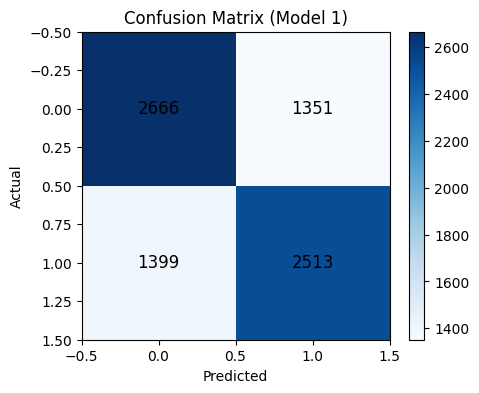

Model 1 AUC: 0.7118484299599911


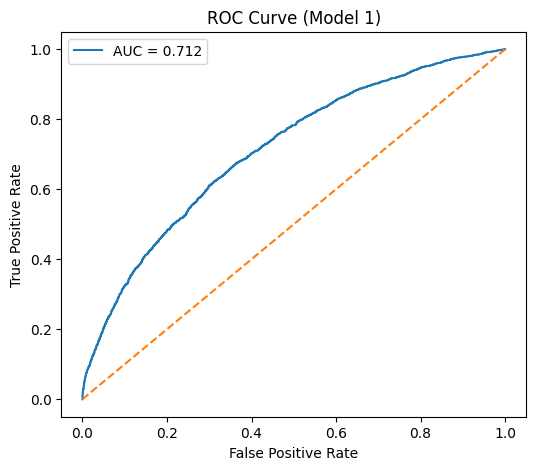

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# predictions for Model 1
y_pred_prob_1 = model1.predict(X_test_sel)
y_pred_1 = (y_pred_prob_1 > 0.5).astype(int)
# accuracy
acc_1 = accuracy_score(y_test_sel, y_pred_1)
print("Model 1 Accuracy:", acc_1, "\n")

# classification report
print("Classification Report (Model 1):")
print(classification_report(y_test_sel, y_pred_1))
# confusion matrix
cm_1 = confusion_matrix(y_test_sel, y_pred_1)
print("Confusion Matrix (Model 1):")
print(cm_1, "\n")

# confusion matrix plot with numbers
plt.figure(figsize=(5,4))
plt.imshow(cm_1, cmap="Blues")
plt.title("Confusion Matrix (Model 1)")
plt.colorbar()
plt.xlabel("Predicted")
plt.ylabel("Actual")
for i in range(cm_1.shape[0]):
    for j in range(cm_1.shape[1]):
        plt.text(j, i, str(cm_1[i, j]),
                 ha='center', va='center',
                 color='black', fontsize=12)

plt.show()
# ROC curve and AUC
fpr_1, tpr_1, thresholds_1 = roc_curve(y_test_sel, y_pred_prob_1)
roc_auc_1 = auc(fpr_1, tpr_1)
print("Model 1 AUC:", roc_auc_1)
plt.figure(figsize=(6,5))
plt.plot(fpr_1, tpr_1, label=f"AUC = {roc_auc_1:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Model 1)")
plt.legend()
plt.show()

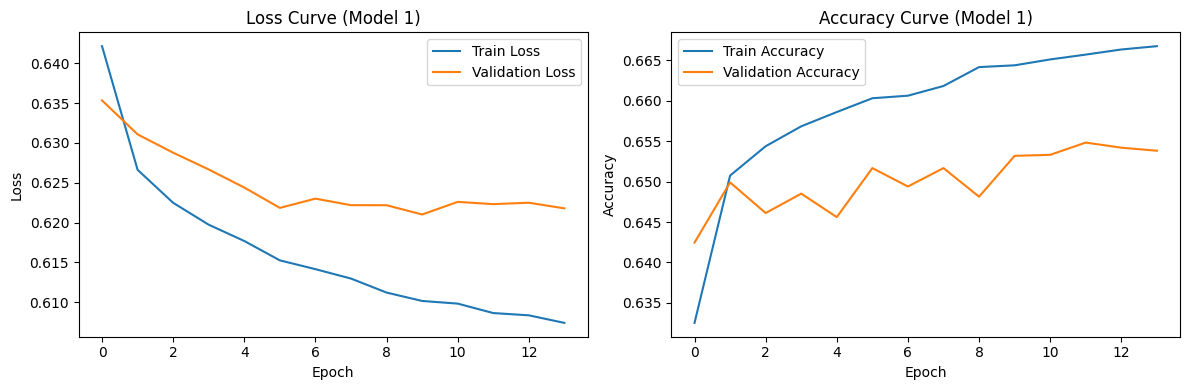

In [7]:

# training curves
plt.figure(figsize=(12,4))

plt.subplot(1, 2, 1)
plt.plot(history1.history['loss'], label="Train Loss")
plt.plot(history1.history['val_loss'], label="Validation Loss")
plt.title("Loss Curve (Model 1)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history1.history['accuracy'], label="Train Accuracy")
plt.plot(history1.history['val_accuracy'], label="Validation Accuracy")
plt.title("Accuracy Curve (Model 1)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


## Model 2

In [ ]:
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping

model2 = models.Sequential()

model2.add(layers.Dense(
    64, activation='relu',
    kernel_regularizer=regularizers.l2(0.001),
    input_shape=(X_train_sel.shape[1],)
))
model2.add(layers.Dropout(0.3))

model2.add(layers.Dense(
    32, activation='relu',
    kernel_regularizer=regularizers.l2(0.001)
))
model2.add(layers.Dropout(0.3))

model2.add(layers.Dense(
    16, activation='relu',
    kernel_regularizer=regularizers.l2(0.001)
))

model2.add(layers.Dense(1, activation='sigmoid'))

model2.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
print(model2.summary())
early2 = EarlyStopping(
    monitor='val_loss',
    patience=4,
    restore_best_weights=True
)
history2 = model2.fit(
    X_train_sel,
    y_train_sel,
    epochs=50,
    batch_size=32,
    validation_data=(X_test_sel, y_test_sel),
    callbacks=[early2],
    verbose=1
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 64)             │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,289 (16.75 KB)

 Trainable params: 4,289 (16.75 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
992/992 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.5813 - loss: 0.7640 - val_accuracy: 0.6421 - val_loss: 0.6932
Epoch 2/50
992/992 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6385 - loss: 0.6898 - val_accuracy: 0.6485 - val_loss: 0.6622
Epoch 3/50
992/992 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6428 - loss: 0.6638 - val_accuracy: 0.6474 - val_loss: 0.6503
Epoch 4/50
992/992 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6485 - loss: 0.6480 - val_accuracy: 0.6490 - val_loss: 0.6416
Epoch 5/50
992/992 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6497 - loss: 0.6434 - val_accuracy: 0.6460 - val_loss: 0.6391
Epoch 6/50
992/992 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6497 - loss: 0.6412 - val_accuracy: 0.6472 - val_loss: 0.6412
Epoch 7/50
992/992 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6495 - loss: 0.6399 - val_accuracy: 0.6496 - val_loss: 0.6345
Epoch 8/50
992/992 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6558 - loss: 0.6356 - val_accura

248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Model 2 Accuracy: 0.6536763778534493 

Classification Report (Model 2):
              precision    recall  f1-score   support

           0       0.66      0.64      0.65      4017
           1       0.64      0.67      0.66      3912

    accuracy                           0.65      7929
   macro avg       0.65      0.65      0.65      7929
weighted avg       0.65      0.65      0.65      7929

Confusion Matrix (Model 2):
[[2562 1455]
 [1291 2621]] 



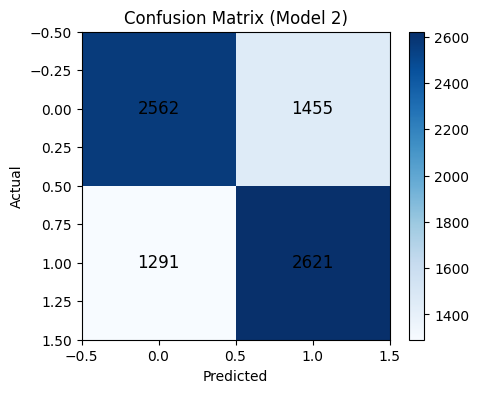

Model 2 AUC: 0.7115276435069157


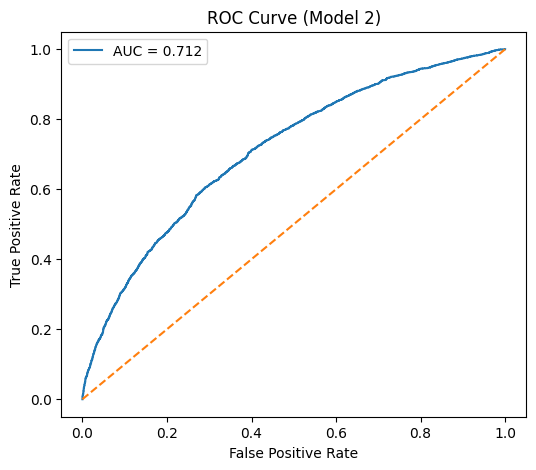

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# predictions for Model 2
y_pred_prob_2 = model2.predict(X_test_sel)
y_pred_2 = (y_pred_prob_2 > 0.5).astype(int)
# accuracy
acc_2 = accuracy_score(y_test_sel, y_pred_2)
print("Model 2 Accuracy:", acc_2, "\n")
# classification report
print("Classification Report (Model 2):")
print(classification_report(y_test_sel, y_pred_2))
# confusion matrix
cm_2 = confusion_matrix(y_test_sel, y_pred_2)
print("Confusion Matrix (Model 2):")
print(cm_2, "\n")
# confusion matrix plot
plt.figure(figsize=(5,4))
plt.imshow(cm_2, cmap="Blues")
plt.title("Confusion Matrix (Model 2)")
plt.colorbar()
plt.xlabel("Predicted")
plt.ylabel("Actual")

for i in range(cm_2.shape[0]):
    for j in range(cm_2.shape[1]):
        plt.text(j, i, str(cm_2[i, j]),
                 ha='center', va='center',
                 color='black', fontsize=12)

plt.show()

# ROC curve and AUC
fpr_2, tpr_2, thresholds_2 = roc_curve(y_test_sel, y_pred_prob_2)
roc_auc_2 = auc(fpr_2, tpr_2)
print("Model 2 AUC:", roc_auc_2)

plt.figure(figsize=(6,5))
plt.plot(fpr_2, tpr_2, label=f"AUC = {roc_auc_2:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Model 2)")
plt.legend()
plt.show()


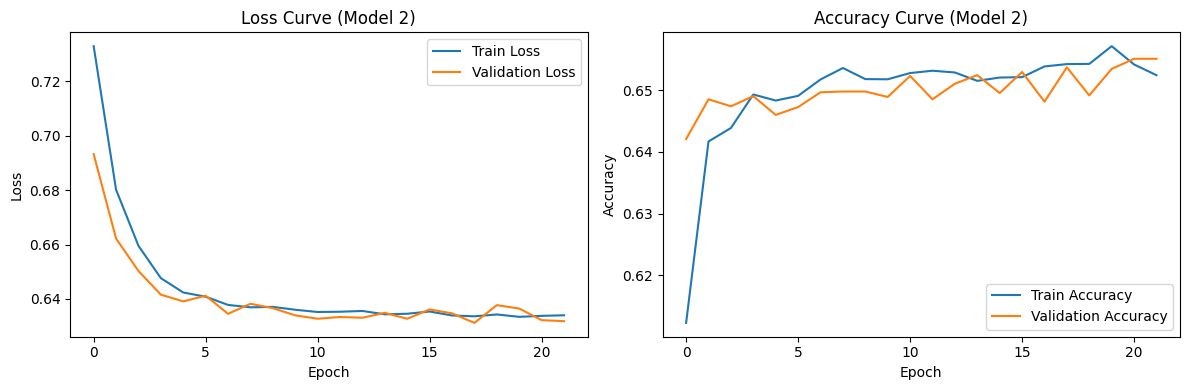

In [10]:
# training curves
plt.figure(figsize=(12,4))

plt.subplot(1, 2, 1)
plt.plot(history2.history['loss'], label="Train Loss")
plt.plot(history2.history['val_loss'], label="Validation Loss")
plt.title("Loss Curve (Model 2)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history2.history['accuracy'], label="Train Accuracy")
plt.plot(history2.history['val_accuracy'], label="Validation Accuracy")
plt.title("Accuracy Curve (Model 2)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()